# **Data Mining - final project 2021/2022**
## Maria Darido, Leonardo Serilli

In [172]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import time 
from scipy.sparse import lil_matrix, kron,identity
from sklearn.model_selection import  train_test_split
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix
from scipy.sparse.linalg import lsqr
from sklearn import svm, datasets

## **(2)** - End host profile using graphlet

Understand the concept of end host profile using graphlet.

- A graphlet is a graph made of size node's type, so-called **graphlet node**: "srcIP", "protocol", "dstIP", "srcport", "dstport", "dstIP". 
    
- A **graphlet edges** define the existence of at least one ﬂow between nodes.

- Each ﬂow creates a directed **graphlet path** from the source IP traversing the appropriate entities in each column.

- Using few informations, graphlets are a useful tool for users behavior profiling.

In [139]:
# Generate a graphlet from src_IP
def getGraphlet(src,df):
    G = nx.DiGraph()
    
    # retrieve edges 
    edges=[]
    for i, row in df[df.srcIP==src].iterrows():
        edges.append((row["srcIP"], row["protocol"]+" "))
        edges.append((row["protocol"]+" ", " "+row["dstIP"]))
        edges.append((" "+row["dstIP"], " "+row["sPort"]+" "))
        edges.append((" "+row["sPort"]+" ", "  "+row["dPort"]+"  "))
        edges.append(("  "+row["dPort"]+"  ", "  "+row["dstIP"]))  
        
    G.add_edges_from(edges)
    
    return G

# Return anomal edges given the src_IP
def getAnomalEdges(src, df):
    
    anomal_edges=[]
    for i, row in df[df.srcIP==src].iterrows():
        if row["activity"] =="anomaly":
            anomal_edges.append((row["srcIP"], row["protocol"]+" "))
            anomal_edges.append((row["protocol"]+" ", " "+row["dstIP"]))
            anomal_edges.append((" "+row["dstIP"], " "+row["sPort"]+" "))
            anomal_edges.append((" "+row["sPort"]+" ", "  "+row["dPort"]+"  "))
            anomal_edges.append(("  "+row["dPort"]+"  ", "  "+row["dstIP"]))  
    
    return anomal_edges

In [140]:
# Graph drawing functions

def drawGraphlet(src, df):
    G=getGraphlet(src, df) 
    anomal_edges=getAnomalEdges(src, df) 
    
    nx.draw(G,graphviz_layout(G, prog='dot') ,with_labels = True,node_color="skyblue", linewidths=2, node_size=400, alpha=0.9) 
    nx.draw_networkx_edges(G, graphviz_layout(G, prog='dot') , edgelist=anomal_edges, width=4, alpha=0.4, edge_color='r') 
    plt.show()
    
def drawGraphlets(df):
    for i in range(len(df.srcIP.unique())):
        fig= plt.figure(figsize=(5, 5)) 
        drawGraphlet(df.srcIP.unique()[i],df) 

## **(3)** - Example graphlet

Build the graphlets corresponding to the following network flows:

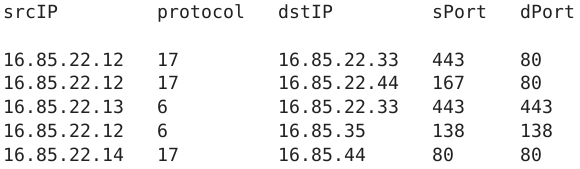

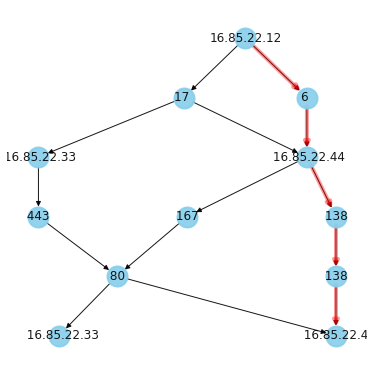

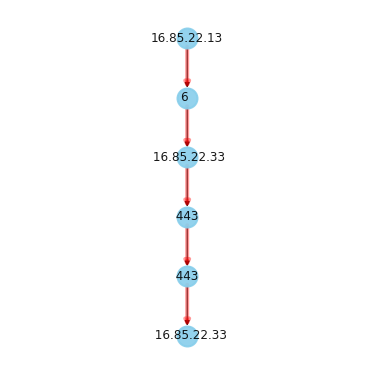

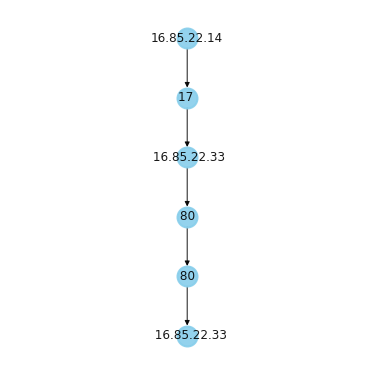

In [278]:
ex_df = pd.DataFrame(
    data={
        'srcIP': ["16.85.22.12","16.85.22.12","16.85.22.13","16.85.22.12","16.85.22.14"],
        'dstIP': ["16.85.22.33","16.85.22.44","16.85.22.33","16.85.22.44", "16.85.22.33"],
        'protocol': ["17","17","6","6", "17"],
        'sPort': ["443","167","443","138", "80"],
        'dPort': ["80","80","443","138","80"],
        'activity': ["normal","normal","anomaly","anomaly","normal"]})
ex_df
drawGraphlets(ex_df)

## **(4)** - retrieving data

A traffic trace with annotated flows (normal or malicious) is provided in the file annotated-trace.txt. You will be using it to build your model of end hosts. 

Note that the srcIP and dstIP are given as simple integers and not with the traditional format with prefixes.

In [127]:
df = pd.read_csv('annotated-trace.csv').astype(str)
df.columns=['srcIP','dstIP','protocol','sPort','dPort','activity']
df

srcIP dstIP protocol sPort dPort activity
0       395   594       17    25   443   normal
1       849   227        6    20    22   normal
2       333   954        6    53    23   normal
3       450    52        6    53    25   normal
4       516   517        1    80    79   normal
...     ...   ...      ...   ...   ...      ...
10064   506   759        6    53    68   normal
10065   719   481       17    53    68   normal
10066   945   994        6    20    80   normal
10067   556    28       89    25    80   normal
10068   256     4       17    53    53   normal

[10069 rows x 6 columns]

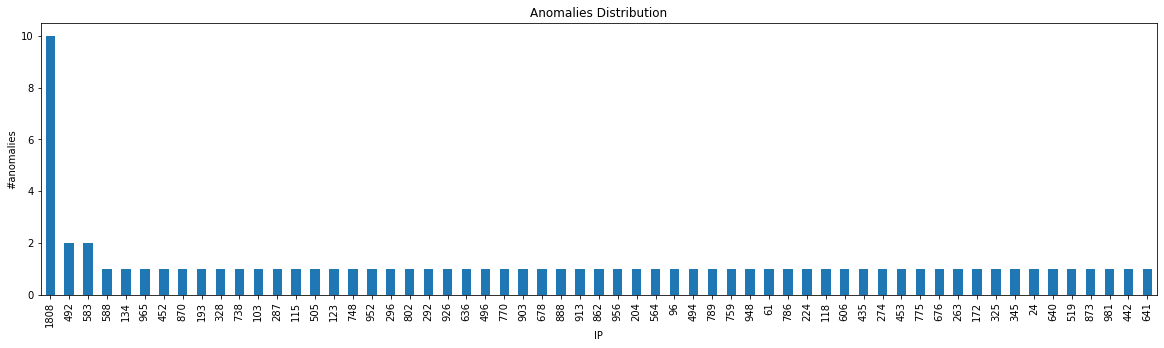

In [128]:
df[df.activity=="anomaly"].srcIP.value_counts().plot(kind="bar", figsize=(20, 5),title='Anomalies Distribution')
plt.xlabel('IP')
plt.ylabel('#anomalies')
plt.show()

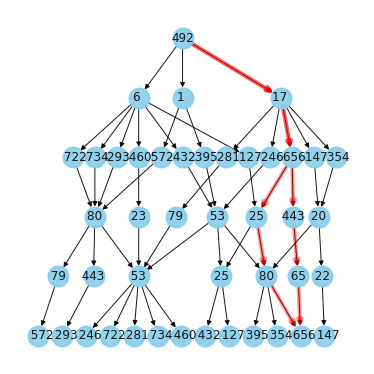

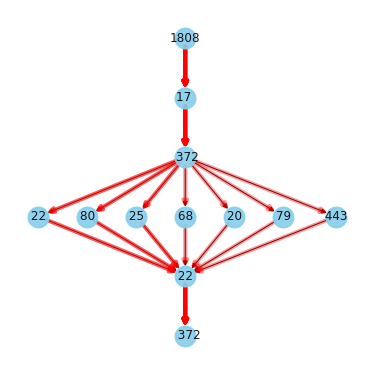

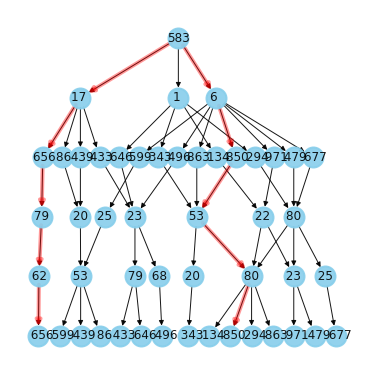

In [130]:
# print Graphlets for srcIPs with highest anomaly distribution 
drawGraphlets(df[df.srcIP.isin(["1808","492","583"])])

# **(5)** Build all Graphlets 

Build all the end host graphlets corresponding to flows in **annotated-trace.txt**

In [153]:
def getAllGraphlets(df):
    graphlets = []
    srcIP = list(df.srcIP.unique())
    for i in range(len(srcIP)):
        graphlets.append(getGraphlet(srcIP[i],df))
    return graphlets

print(" #graphlets built ->", len(getAllGraphlets(df)))

 #graphlets built -> 1001


## **(6)** - Bring to high dimensional space

Build a function to transform the graphlets into the **high dimensional space of the random walk kernel**

-  The random walk kernel consider the sum over all length of walks, so the feature values are given by $\sum_{k=0}^{n} A^k$ whe A contains the number of walk of lenght k between each couple of vertixes.

In [168]:
def hasAnomalies(src,df):
    graph=df[df.srcIP==src]
    return len(graph[graph.activity=="anomaly"]) != 0

# Get the feature vector given a graphlet and a walk lenght 
def getFeatVect(walk_len, graphlet):
    adj=nx.adjacency_matrix(graphlet,nodelist=sorted(graphlet.nodes())).todense() 
    identity =np.identity(adj.shape[0], dtype = int ) 
    
    adj1=adj # 1 walk adjacency matrix
    res=identity+adj
    
    for i in range(1,walk_len):
        adj=np.dot(adj,adj1) # Dot product
        res+=adj
    
    # SVM of scikit-learn accept as input a matrix of features, for this reason we need to flat our adjacency matrix into a vector
    return np.squeeze(np.asarray(res)).flatten() # Flat of the adjacency matrix

# Transform all graphlets into high dimensional space of the random walk kernel with length 4
def allFeatures(df,pad):
    Y=[]
    graphlets = getAllGraphlets(df)
    features = [] 
    maxlen=0 
    srcIP = list(df.srcIP.unique()) 
    
    # get the feature vector of eahc graphlet
    for i in range(len(srcIP)): 
        features.append(getFeatVect(4,graphlets[i]))
        if (len(features[i]) > maxlen): 
                maxlen=len(features[i]) 
        
        # label anomalies 
        if (hasAnomalies(srcIP[i],df)): 
            Y.append("anomaly")
        else:
            Y.append("normal")
            
    # Padding the feature vector
    for i in range(len(srcIP)):
        features[i] = np.pad(features[i], (0,maxlen-features[i].size), 'constant', constant_values=(pad))
        
    return features, Y, maxlen

features, Y, maxlen = allFeatures(df,0)

## **(7)** - SVM 
Use a Support Vector Machine algorithm to build a model separating the normal from the malicious end hosts in the high dimensional space.

In [201]:
# Splitting feature vector and label vector in training and test  
X_train, X_test, y_train, y_test = train_test_split(features, Y, test_size=0.2,random_state=0)

# create our model using the Training and Test data
model = svm.SVC(gamma='auto',kernel='poly')
model.fit(X_train, y_train)

time_start = time.perf_counter()
y_pred= model.predict(X_test) 
time_elapsed = (time.perf_counter() - time_start)

# Computation time and Score
print("Computation time: ", time_elapsed,"s") 
print(accuracy_score(y_test,y_pred)) 

# Training the model using all the data we have as Training data
model1 = svm.SVC(gamma='auto',kernel='linear')
model1.fit(features, Y)

Computation time:  0.15801561399894126 s
0.9203980099502488


SVC(gamma='auto', kernel='linear')

## **(8)** - Kernel Trick 

Use now the kernel trick to avoid having to map your graphlet in the high dimensional space. Compare the computation time.

- The usage of a kernel trick is to avoid the mapping of the graphlets in the high dimensional space. The trick takes advantage of the **Direct Product** and bring a complecity **O(n^6)** which can be reduced by taking advantage of the **Kronecker Product**. 

In [203]:
def randomWalkKernelTrick(Ax, Ay):
    res = []
    for i in range(len(Ax)):
        temp=[]
        A1 = Ax[i][Ax[i] != -1] # Remove padding
        A1 = A1.reshape(int(math.sqrt(A1.size)),int(math.sqrt(A1.size))) # Resize into a matrix
        for j in range(len(Ay)):              
            A2 = Ay[j][Ay[j] != -1]  # Remove padding          
            A2 = A2.reshape(int(math.sqrt(A2.size)),int(math.sqrt(A2.size))) # Resize into a matrix
            Az = np.kron(A1,A2) # performing Kronecker product
            LAMBDA = 0.1
            i=np.identity(Az.shape[0], dtype = int )
            temp.append(np.linalg.inv(i-LAMBDA*Az).sum())
        res.append(temp)
        print("Iteration:",len(res))
    return res

In [204]:
features, Y, maxlen=allFeatures(df,-1)

# computationally too much expensive, use a subset of data 
subsetSize= 50
model2 = svm.SVC(gamma='auto',kernel=randomWalkKernelTrick)
model2.fit(features[:subsetSize], Y[:subsetSize])

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50


SVC(gamma='auto', kernel=<function randomWalkKernelTrick at 0x7f9bd664f4c0>)

In [205]:
time_start = time.perf_counter()
y_pred= model2.predict(features[subsetSize:2*subsetSize])
time_elapsed = (time.perf_counter()  - time_start)

# Computation time and Score
print("Computation time: ", time_elapsed,"s")

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Computation time:  485.2934374970009 s


## **(9)** - Apply model to **not-annotated-trace.txt**

Apply your model to the traffic trace provided in the file not-annotated-trace.txt. <br>
- Do you detect anomalous traffic? Plot them.  <br>
- To which kind of attacks, could they correspond? <br>

In [209]:
# read the unclassified data 
unclassified_df = pd.read_csv('not-annotated-trace.csv').astype(str) 
unclassified_df.columns=['srcIP','dstIP','protocol','sPort','dPort']
unclassified_df

srcIP dstIP protocol sPort dPort
0       259   218       89    79    25
1       959   855        1    20    22
2       859   592        6    25    68
3       759    84       17    80   443
4        82   343        1    25    68
...     ...   ...      ...   ...   ...
10064   799   222       17    80    53
10065   810    50       17    22    22
10066   814   145        6   443    79
10067   276   817        6    80    53
10068   674   140        1    80    22

[10069 rows x 5 columns]

In [263]:
# get all graphlets
graphlets= getAllGraphlets(unclassified_df) 

srcIPs = list(unclassified_df.srcIP.unique())
featuresUnclassified = []

# Building feature vector
for i in range(len(srcIPs)):
    featuresUnclassified.append(computeFeatureVector(4,graphlets[i])) 

# padding with zeros
for i in range(len(srcIPs)):
    featuresUnclassified[i]=np.squeeze(np.resize(featuresUnclassified[i],(1,maxlen))) 

In [264]:
# Predictions without Kernel trick
time_start = time.perf_counter()
y_pred= model1.predict(featuresUnclassified)
time_elapsed = (time.perf_counter()  - time_start)

# Computation time
print("Computation time: ", time_elapsed,"s")

predictions = pd.DataFrame({'srcIP':srcIPs,'activity':y_pred})

Computation time:  0.8527692699972249 s


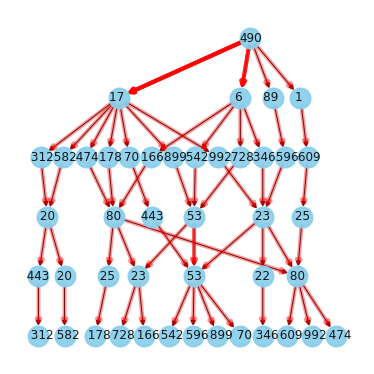

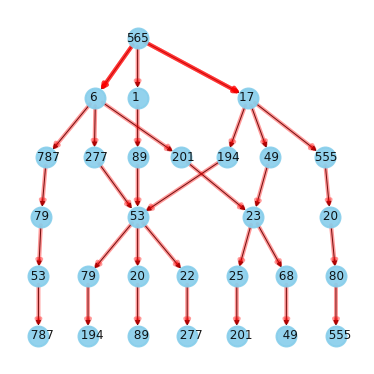

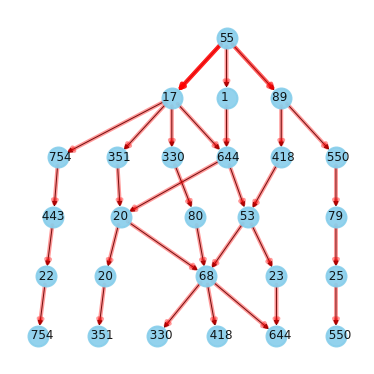

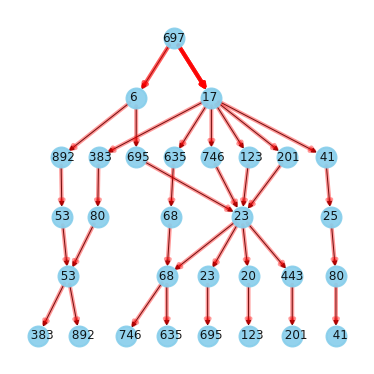

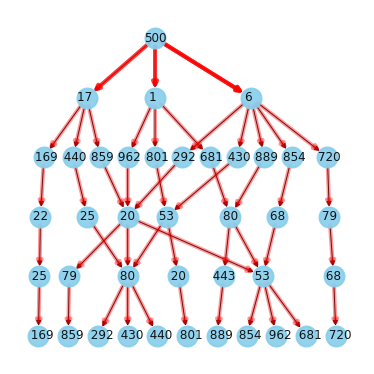

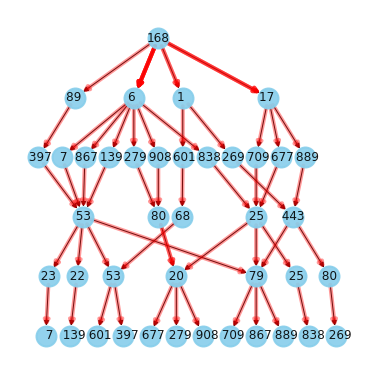

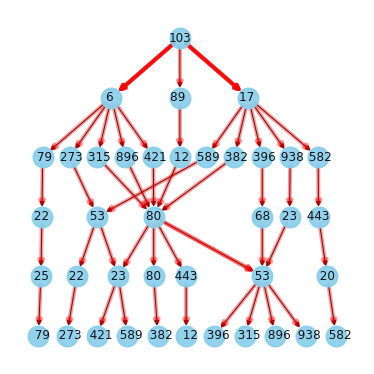

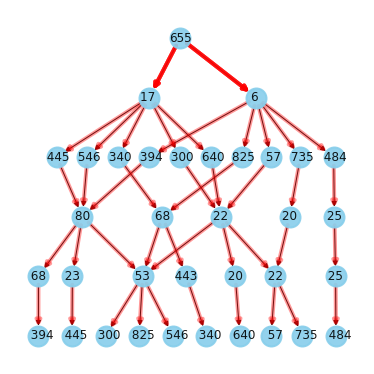

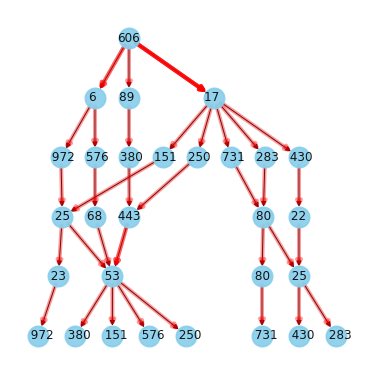

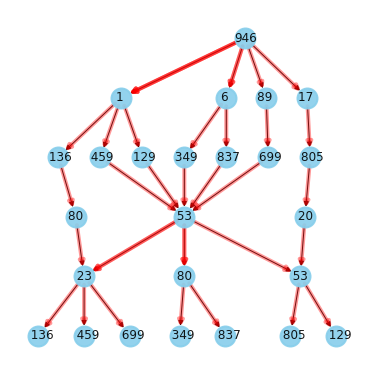

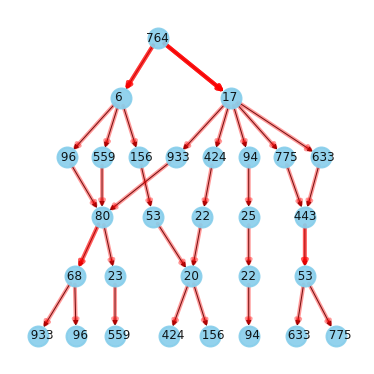

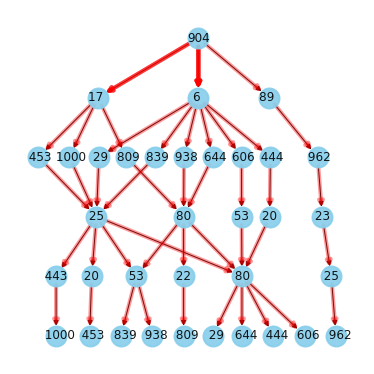

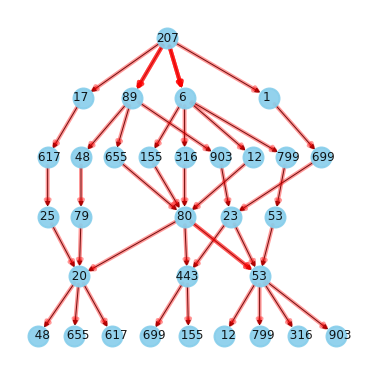

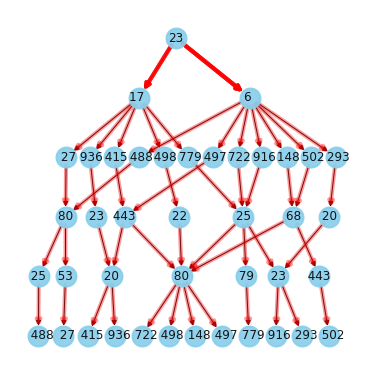

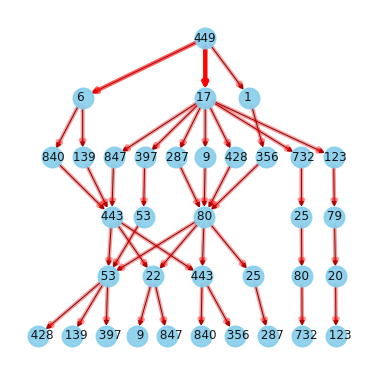

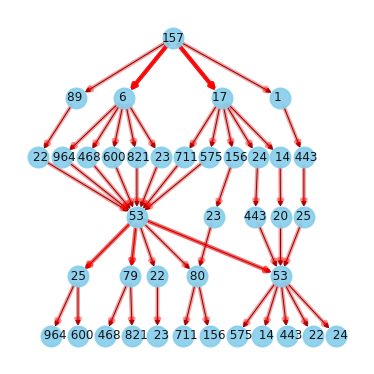

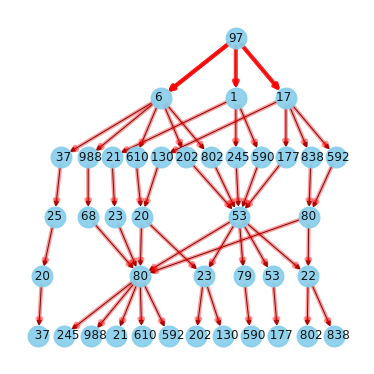

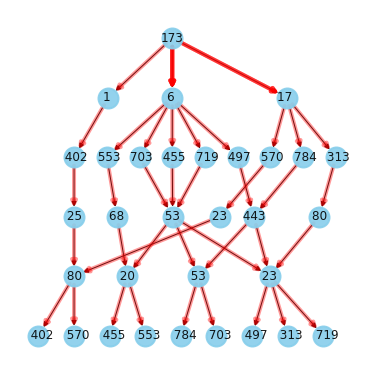

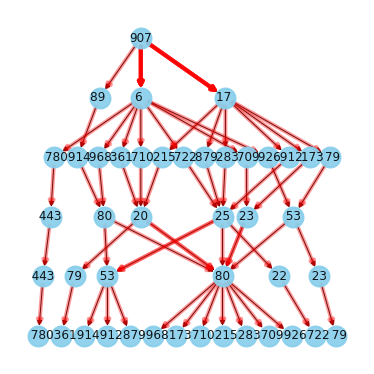

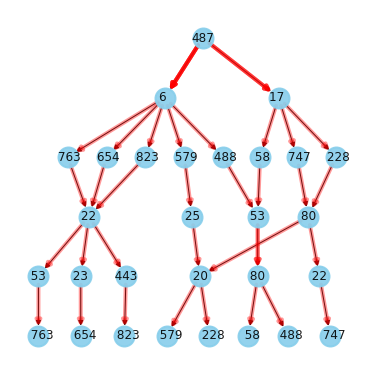

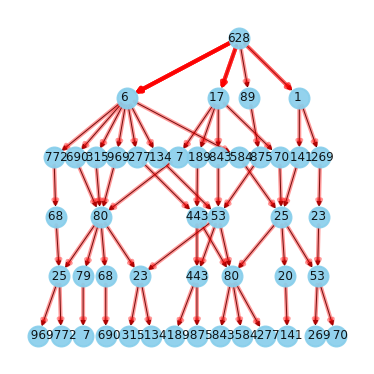

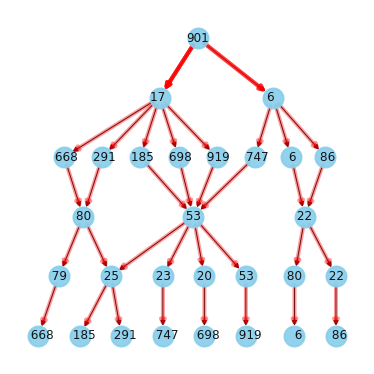

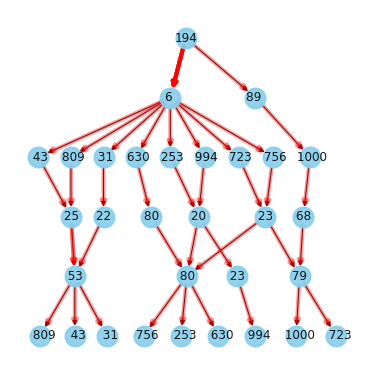

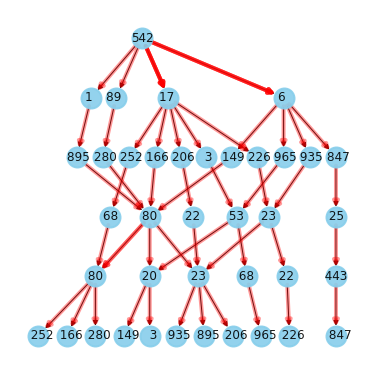

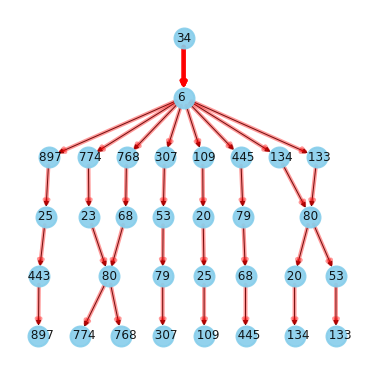

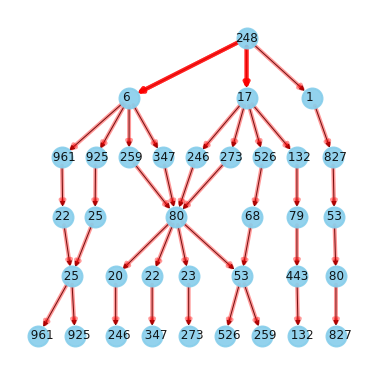

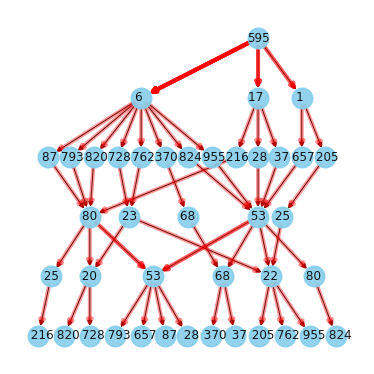

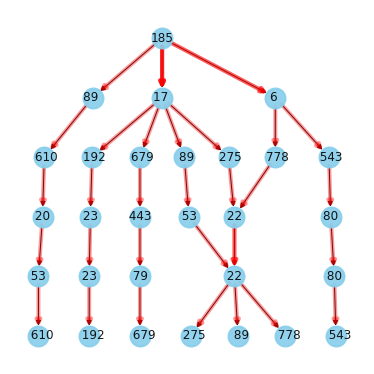

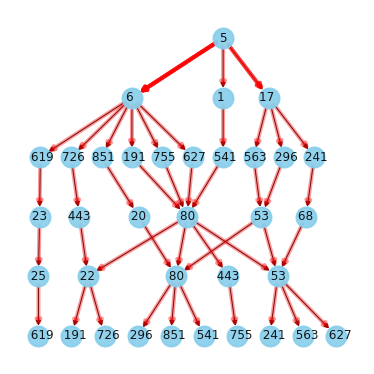

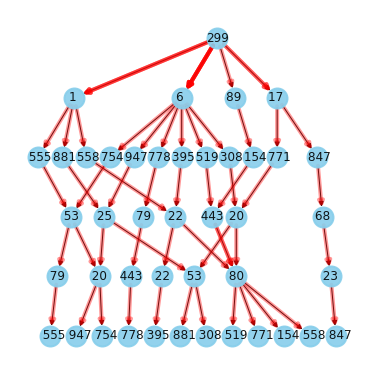

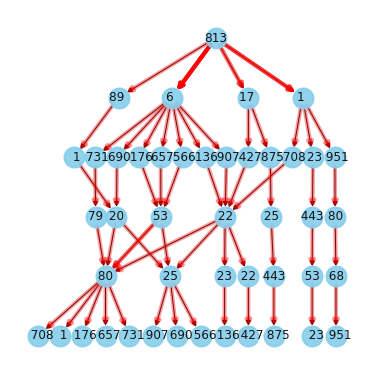

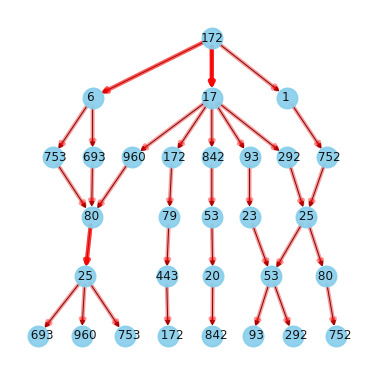

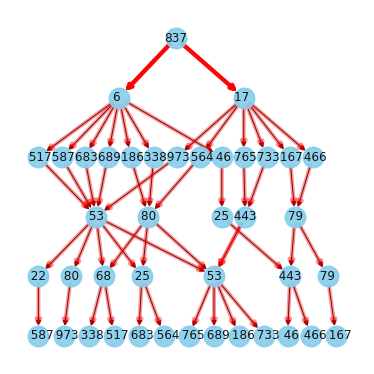

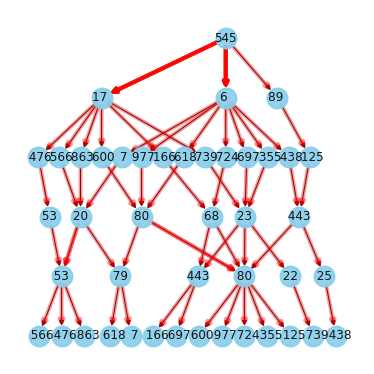

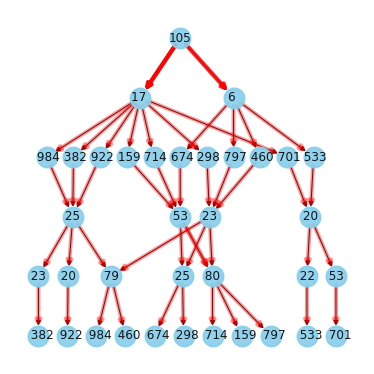

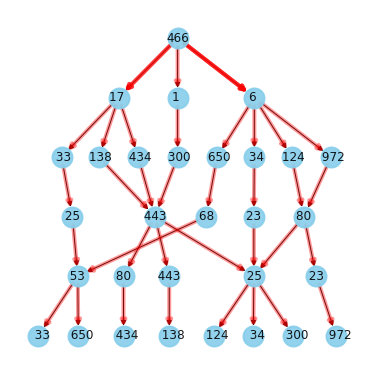

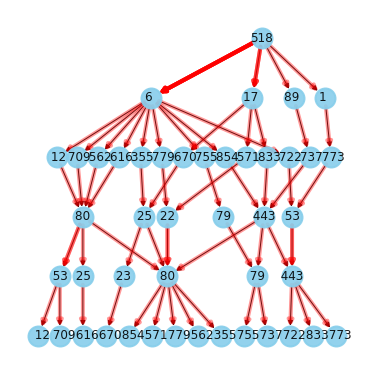

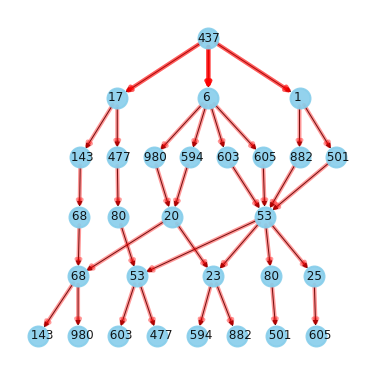

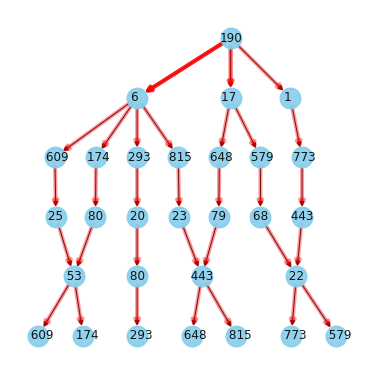

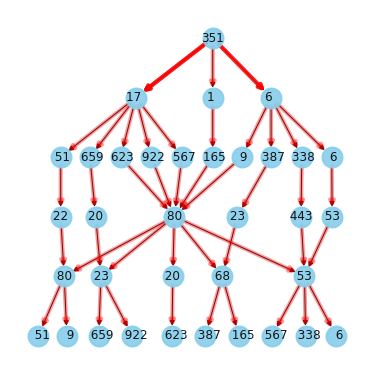

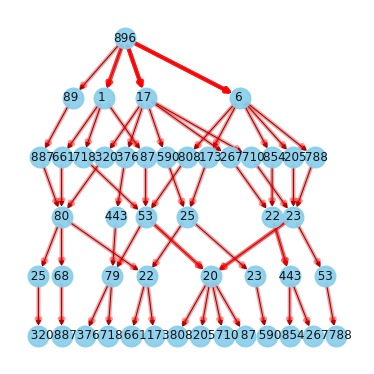

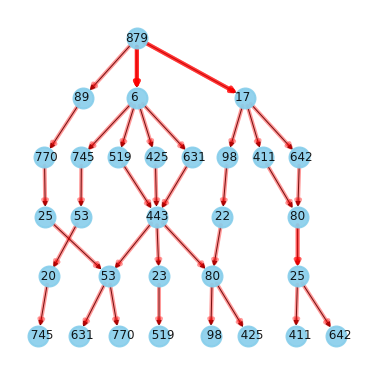

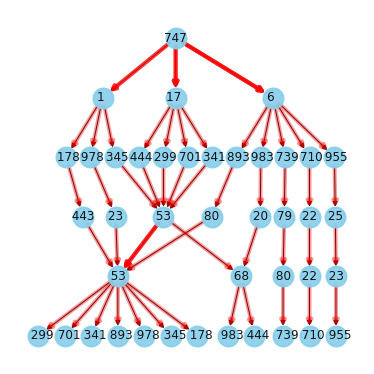

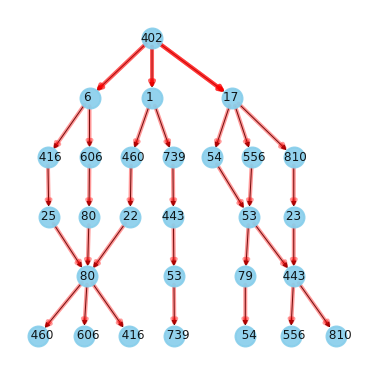

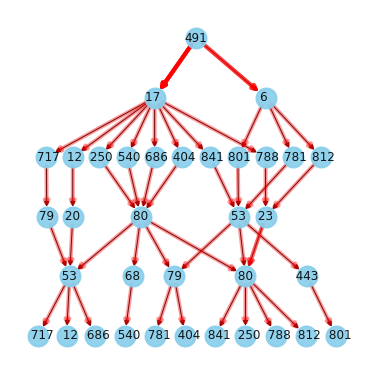

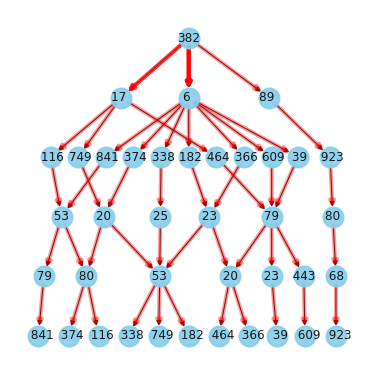

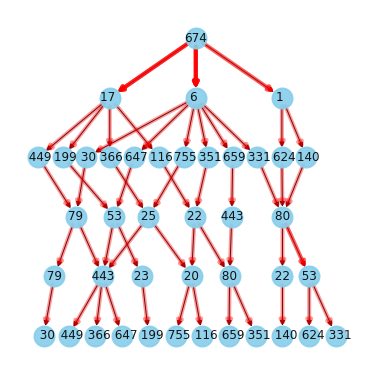

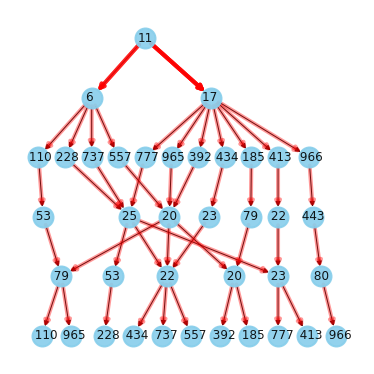

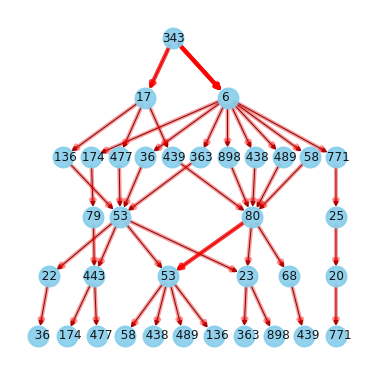

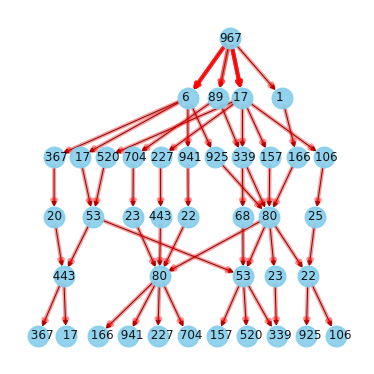

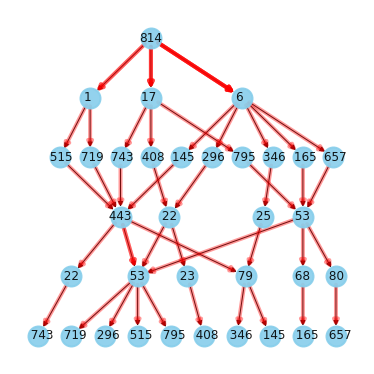

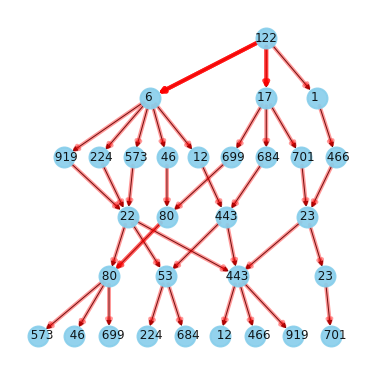

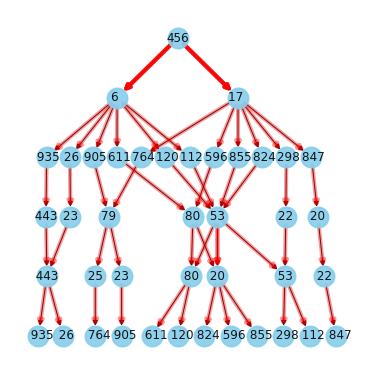

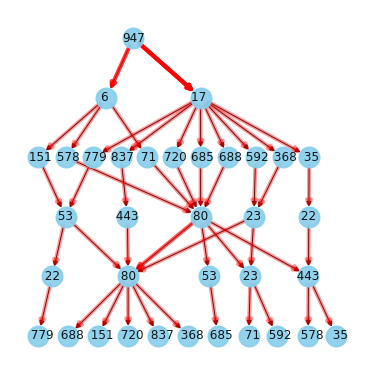

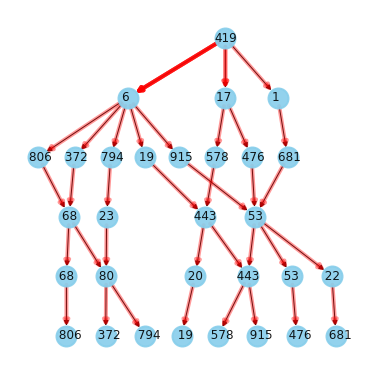

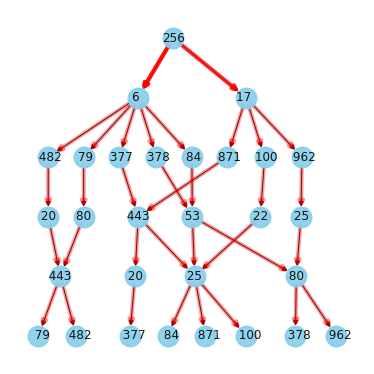

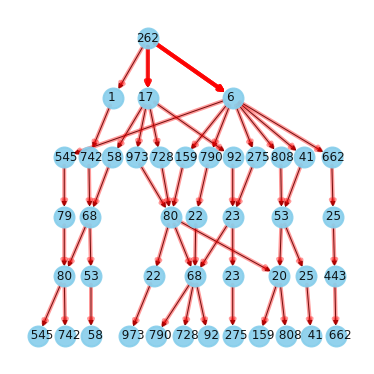

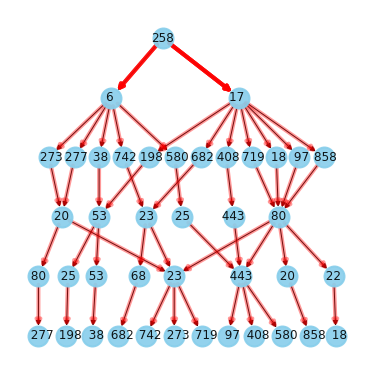

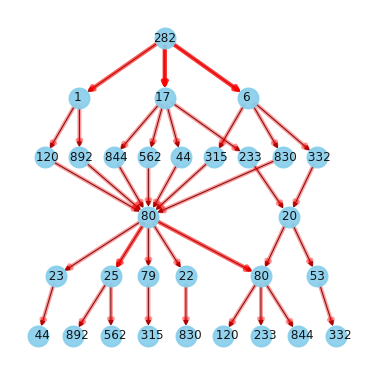

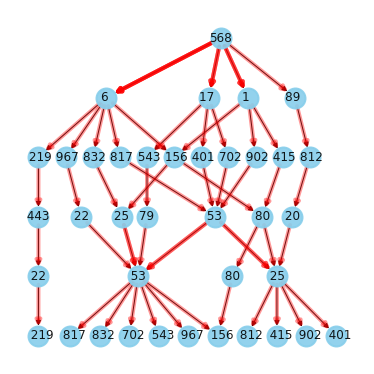

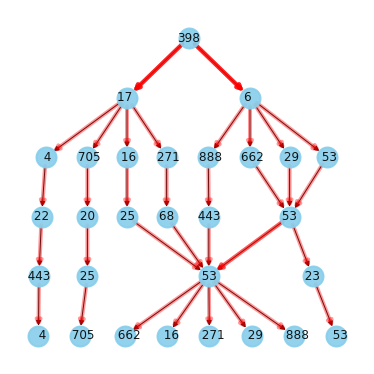

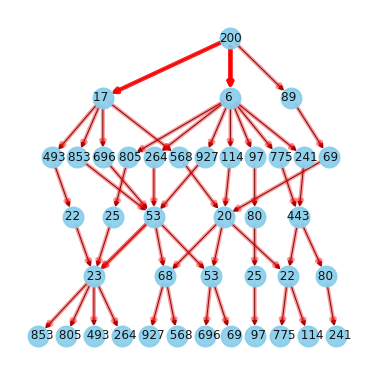

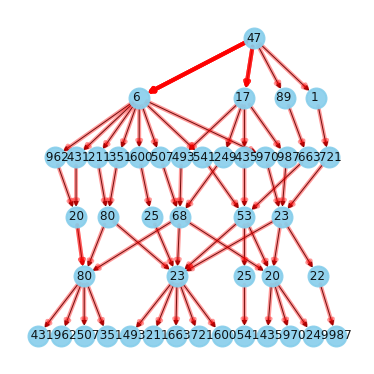

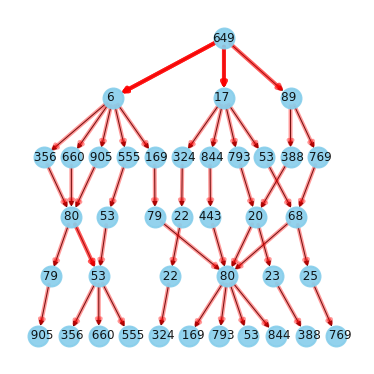

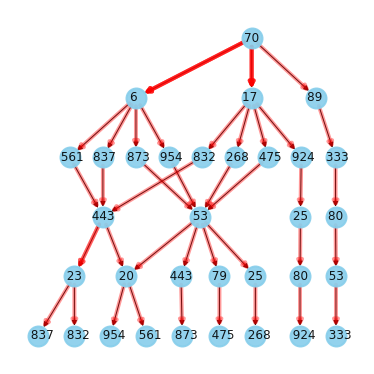

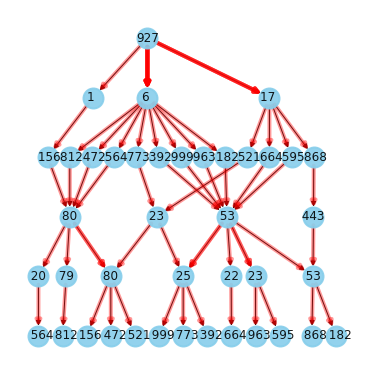

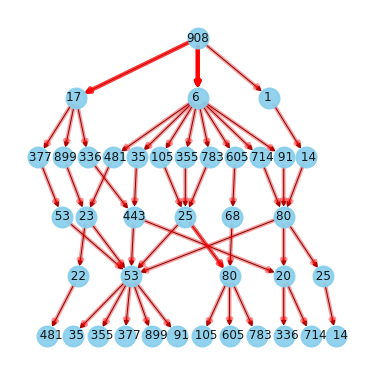

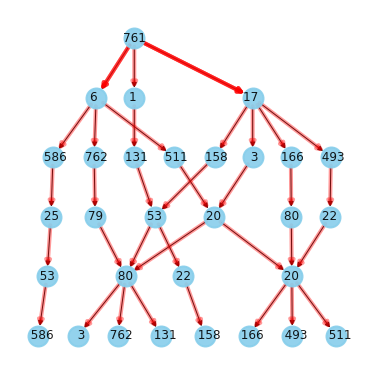

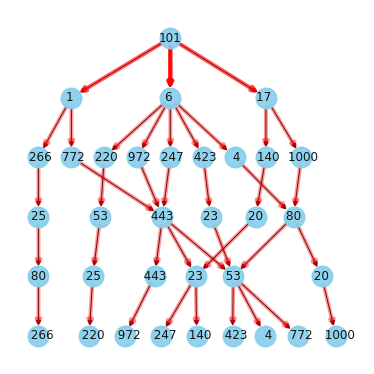

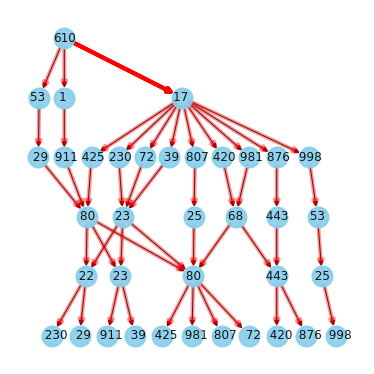

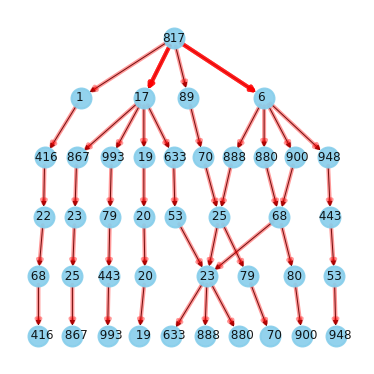

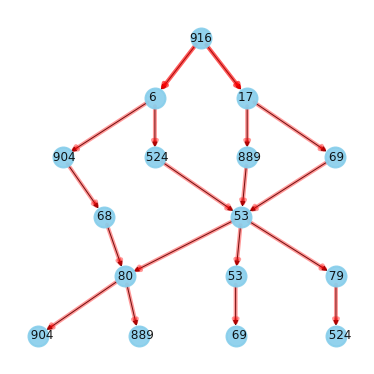

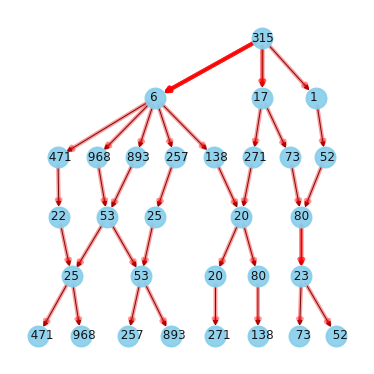

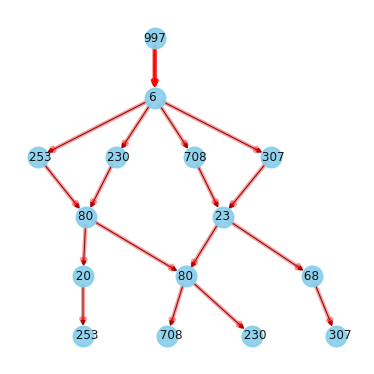

In [272]:
# get IPs with an anomaly predicted 
pred_srcIPs = predictions[predictions.activity=="anomaly"]["srcIP"]

# retrieve the data associated with those IPs
pred_df=[]
for i in pred_srcIPs:
    pred_df.append(unclassified_df[unclassified_df.srcIP==i])
    
pred_df = pd.concat(pred_df)
pred_df["activity"] = ["anomaly" for i in range(len(pred_df))]

# draw graphlets associated with thos IPs
drawGraphlets(pred_df)

In [273]:
subset_size = 7

# Kernel trick predictions
time_start = time.perf_counter()
y_pred= model2.predict(featuresUnclassified[:subset_size])
time_elapsed = (time.perf_counter()  - time_start)

# Computation time
print("Computation time: ", time_elapsed,"s")

KT_predictions = pd.DataFrame({'srcIP':srcIPs[:subset_size],'activity':y_pred})

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Computation time:  335.22999352699844 s


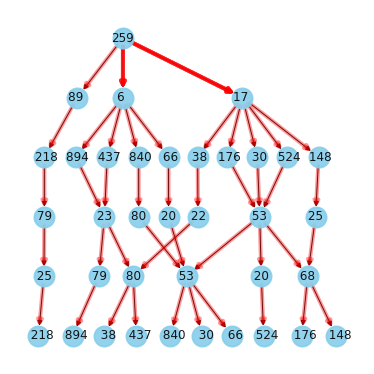

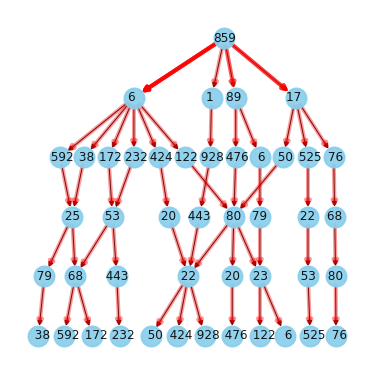

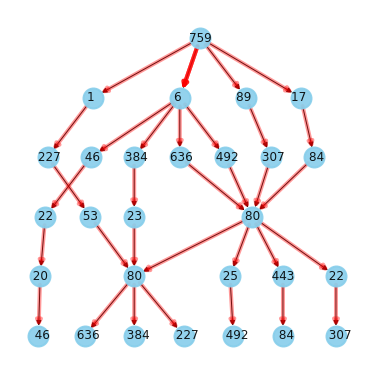

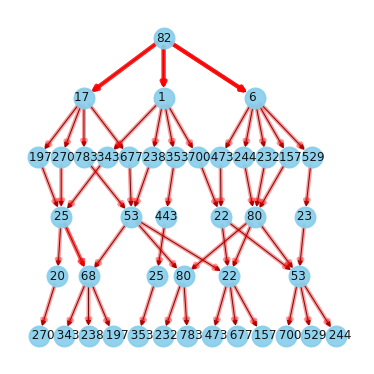

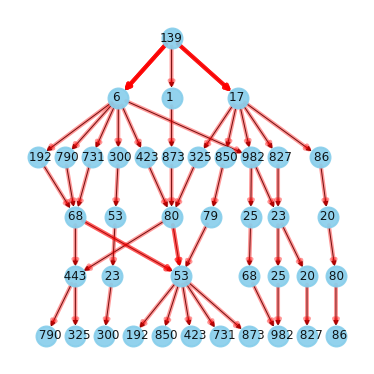

In [274]:
# get IPs with an anomaly predicted 
pred_srcIPs = KT_predictions[KT_predictions.activity=="anomaly"]["srcIP"]

# retrieve the data associated with those IPs
pred_df=[]
for i in pred_srcIPs:
    pred_df.append(unclassified_df[unclassified_df.srcIP==i])
    
pred_df = pd.concat(pred_df)
pred_df["activity"] = ["anomaly" for i in range(len(pred_df))]

# draw graphlets associated with thos IPs
drawGraphlets(pred_df)

## **(10)** - Discuss

Discuss potential false positives and false negatives

- A model that predicts few anomalies than the actual ones is worst than one that predict more. The reason is that a false negative, so an attack not predicted by the model, is worst than a false positive, so a normal behavior interpreted as an attack. 

- Those are the reasons why is also important to analyse the **confusion matrix** of a model and also to apply cross validation techniques.